In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import KMeans
import h5py
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
DIR_DATASET = "./data_set/"

In [2]:
filename = "N-CMAPSS_DS08a-009.h5"

In [3]:
# Load data
with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))

W shape: (8608386, 4)
X_s shape: (8608386, 14)
X_v shape: (8608386, 14)
T shape: (8608386, 10)
A shape: (8608386, 4)


In [4]:
df_A = DataFrame(data=A, columns=A_var)
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values


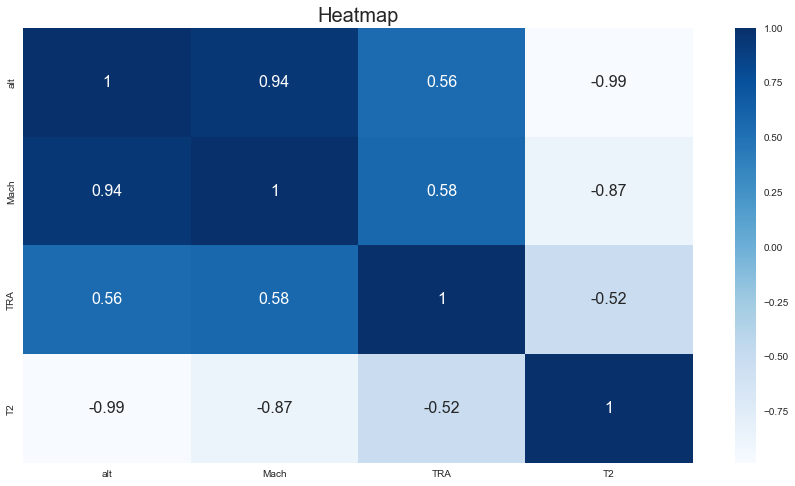

In [5]:
plt.figure(figsize=(15,8))
sns.heatmap(df_W.drop(["unit"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

In [6]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s['unit'] = df_W['unit'].values
df_X_s['alt'] = df_W['alt'].values
df_X_s['Mach'] = df_W['Mach'].values
df_X_s['TRA'] = df_W['TRA'].values
df_X_s['T2'] = df_W['T2'].values
df_X_s

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2
0,632.830608,1525.667253,1953.949543,1319.505339,20.431550,14.614995,20.742691,26.314587,448.927946,455.757278,16.731336,2271.183351,8867.826621,5.534608,1.0,3003.0,0.392490,84.286507,523.610932
1,632.859504,1525.696748,1953.927850,1319.441504,20.433361,14.616348,20.744529,26.317586,448.944360,455.774913,16.729315,2271.271698,8867.930859,5.534581,1.0,3008.0,0.392994,84.286507,523.633379
2,632.889882,1525.725093,1953.948358,1319.424113,20.435964,14.618606,20.747172,26.321283,448.970022,455.801296,16.728307,2271.312307,8868.013734,5.534890,1.0,3012.0,0.393561,84.286507,523.662756
3,632.920333,1525.759185,1953.952618,1319.375074,20.437438,14.619858,20.748668,26.323778,448.979763,455.811807,16.725681,2271.397942,8868.125342,5.534886,1.0,3020.0,0.394254,84.286507,523.689414
4,632.956016,1525.785508,1953.952454,1319.329057,20.440027,14.622166,20.751297,26.327640,448.994394,455.827309,16.723509,2271.452480,8868.204160,5.534968,1.0,3026.0,0.394947,84.286507,523.723272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8608381,577.528601,1321.635848,1578.592550,1160.810649,16.564442,13.615548,16.816692,19.501735,265.849007,270.801149,14.538697,1777.137884,8193.388620,2.647037,15.0,3024.0,0.230769,39.111050,513.294209
8608382,577.077169,1320.376511,1577.167980,1160.792675,16.537771,13.606607,16.789615,19.453720,264.960398,269.890748,14.538870,1772.360892,8188.766122,2.636919,15.0,3016.0,0.227745,38.847378,513.183341
8608383,577.033125,1319.865538,1576.629413,1160.848177,16.547822,13.627178,16.799819,19.455395,264.648662,269.573484,14.540629,1769.640210,8186.708495,2.633749,15.0,3012.0,0.231966,38.671600,513.397445
8608384,577.038478,1319.659073,1576.255366,1160.765037,16.555576,13.639659,16.807691,19.460436,264.541989,269.465845,14.543199,1768.468579,8185.866405,2.632082,15.0,3006.0,0.234234,38.583710,513.521326


In [7]:
df_X_s.describe()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2
count,8.608386e+06,8.608386e+06,8.608386e+06,8.608386e+06,8.608386e+06,8.608386e+06,8.608386e+06,8.608386e+06,8.608386e+06,8.608386e+06,8.608386e+06,8.608386e+06,8.608386e+06,8.608386e+06,8.608386e+06,8.608386e+06,8.608386e+06,8.608386e+06,8.608386e+06
mean,5.695395e+02,1.332654e+03,1.641057e+03,1.131118e+03,1.294756e+01,1.011570e+01,1.314473e+01,1.595267e+01,2.371950e+02,2.413160e+02,1.010138e+01,1.956677e+03,8.239682e+03,2.538923e+00,8.344847e+00,1.561057e+04,5.369075e-01,6.042170e+01,4.903205e+02
std,2.130257e+01,6.898511e+01,1.248311e+02,6.342451e+01,2.897868e+00,2.436055e+00,2.941998e+00,3.466218e+00,5.947655e+01,6.029159e+01,2.766078e+00,1.880678e+02,2.284429e+02,7.898484e-01,4.235085e+00,8.110530e+03,1.191981e-01,1.845794e+01,2.006775e+01
min,4.841928e+02,1.070974e+03,9.434676e+02,6.904360e+02,5.915764e+00,4.373175e+00,6.005851e+00,6.912274e+00,8.032398e+01,8.207711e+01,4.128674e+00,1.468845e+03,7.367442e+03,3.231093e-01,1.000000e+00,3.001000e+03,3.150000e-04,2.355452e+01,4.213779e+02
25%,5.543929e+02,1.285306e+03,1.554813e+03,1.087098e+03,1.046318e+01,7.956804e+00,1.062252e+01,1.311185e+01,1.925422e+02,1.960600e+02,7.617604e+00,1.836521e+03,8.083249e+03,1.976160e+00,5.000000e+00,9.014000e+03,4.433310e-01,4.658170e+01,4.739982e+02
50%,5.673256e+02,1.328130e+03,1.649884e+03,1.120697e+03,1.320426e+01,1.040700e+01,1.340534e+01,1.599784e+01,2.245273e+02,2.287393e+02,1.027107e+01,2.003598e+03,8.231452e+03,2.326688e+00,8.000000e+00,1.419200e+04,5.436900e-01,6.459915e+01,4.946543e+02
75%,5.836947e+02,1.372829e+03,1.717374e+03,1.167025e+03,1.522791e+01,1.204459e+01,1.545981e+01,1.842317e+01,2.722379e+02,2.769592e+02,1.222948e+01,2.116141e+03,8.377097e+03,2.939371e+00,1.200000e+01,2.249200e+04,6.373080e-01,7.716742e+01,5.068476e+02
max,6.338794e+02,1.535034e+03,1.994448e+03,1.363102e+03,2.044372e+01,1.559222e+01,2.075505e+01,2.634954e+01,4.510617e+02,4.571331e+02,1.673134e+01,2.290649e+03,8.879011e+03,5.647945e+00,1.500000e+01,3.503300e+04,7.492590e-01,8.876890e+01,5.337279e+02


-2.801367412835483e-16 1.0000000000000009
(8608386, 18)


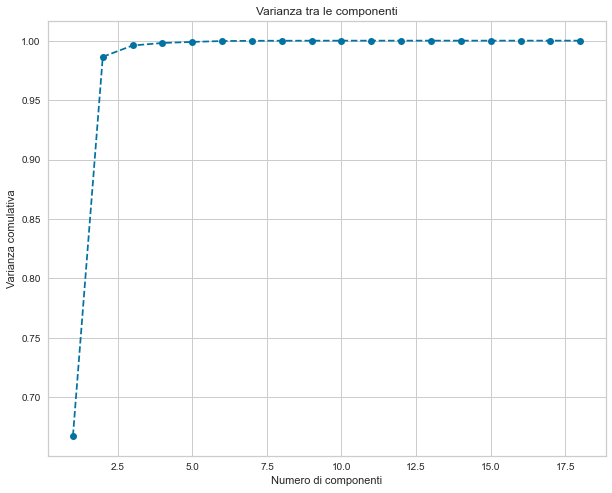

In [8]:
df_X_s_norm = KMeans.normalize_df(df_X_s.drop(columns=["unit"]))
KMeans.plot_variance_ratio(df_X_s_norm)

it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
Numero di cluster (k-means): 3


KMeans(n_clusters=3, random_state=42)

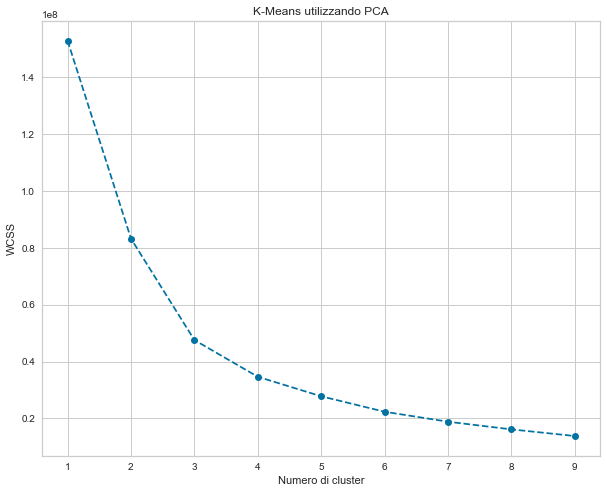

In [9]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_X_s_norm,2)
wcss = []
for i in range(1,10):
     kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
     kmeans_pca.fit(scores_pca)
     wcss.append(kmeans_pca.inertia_)
     print("it",str(i))
plt.figure(figsize=(10,8))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")
print("Numero di cluster (k-means):",kl.elbow)
kmeans_pca = KMeans.KMeans(n_clusters=kl.elbow,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

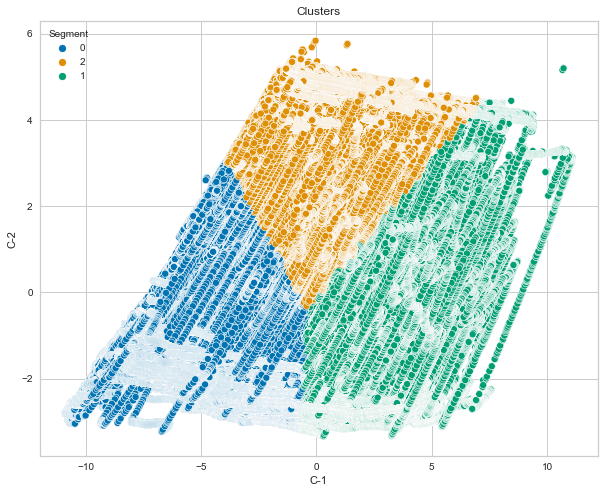

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,unit,alt,Mach,TRA,T2,C-1,C-2,Segm K-means PCA,Segment
0,632.830608,1525.667253,1953.949543,1319.505339,20.431550,14.614995,20.742691,26.314587,448.927946,455.757278,...,5.534608,1.0,3003.0,0.392490,84.286507,523.610932,-10.670432,-2.575537,0,0
1,632.859504,1525.696748,1953.927850,1319.441504,20.433361,14.616348,20.744529,26.317586,448.944360,455.774913,...,5.534581,1.0,3008.0,0.392994,84.286507,523.633379,-10.670687,-2.576694,0,0
2,632.889882,1525.725093,1953.948358,1319.424113,20.435964,14.618606,20.747172,26.321283,448.970022,455.801296,...,5.534890,1.0,3012.0,0.393561,84.286507,523.662756,-10.671760,-2.577819,0,0
3,632.920333,1525.759185,1953.952618,1319.375074,20.437438,14.619858,20.748668,26.323778,448.979763,455.811807,...,5.534886,1.0,3020.0,0.394254,84.286507,523.689414,-10.671575,-2.579652,0,0
4,632.956016,1525.785508,1953.952454,1319.329057,20.440027,14.622166,20.751297,26.327640,448.994394,455.827309,...,5.534968,1.0,3026.0,0.394947,84.286507,523.723272,-10.672076,-2.580973,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8608381,577.528601,1321.635848,1578.592550,1160.810649,16.564442,13.615548,16.816692,19.501735,265.849007,270.801149,...,2.647037,15.0,3024.0,0.230769,39.111050,513.294209,-3.139757,3.343615,2,2
8608382,577.077169,1320.376511,1577.167980,1160.792675,16.537771,13.606607,16.789615,19.453720,264.960398,269.890748,...,2.636919,15.0,3016.0,0.227745,38.847378,513.183341,-3.103899,3.382001,2,2
8608383,577.033125,1319.865538,1576.629413,1160.848177,16.547822,13.627178,16.799819,19.455395,264.648662,269.573484,...,2.633749,15.0,3012.0,0.231966,38.671600,513.397445,-3.093764,3.395860,2,2
8608384,577.038478,1319.659073,1576.255366,1160.765037,16.555576,13.639659,16.807691,19.460436,264.541989,269.465845,...,2.632082,15.0,3006.0,0.234234,38.583710,513.521326,-3.090554,3.402922,2,2


In [10]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)

In [11]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)

KMeans.calculate_centroids(df_segm_pca_kmeans,scores_pca,"",0)

-3.242209284443775e-15 1.0000000000000016
(2717294, 19)
-5.023589319631256e-15 0.9999999999999987
(3503617, 19)
-2.2779910487904857e-15 0.9999999999999991
(2387475, 19)


,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,group
mean,594.569474,1408.603446,1762.259302,1204.452319,15.605095,11.789388,15.842736,19.568096,308.340769,313.388414,12.357885,2079.374693,8488.592300,3.482877,7.961067,10221.266561,0.477603,68.322671,504.637409,0.0
mean,554.205240,1313.718201,1636.346720,1093.941934,10.018459,7.579412,10.171024,12.652983,195.878590,199.118215,7.280791,2025.616282,8183.908104,2.103030,8.861687,24109.886047,0.650473,70.562637,469.376787,1.0
mean,563.554851,1274.000625,1510.024750,1102.207394,14.221352,11.932810,14.437920,16.680089,216.852576,221.212371,11.672357,1715.862170,8038.235588,2.104240,8.023183,9271.650460,0.437748,36.547445,504.760815,2.0


Text(0, 0.5, 'Flight Class # [-]')

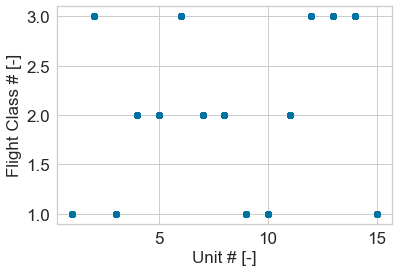

In [12]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [13]:
dic = {}
for i in range(1,len(set(df_A.unit))+1):
    dic[i] = int(df_A[df_A.unit==i]["Fc"].iloc[0])
dic

{1: 1,
 2: 3,
 3: 1,
 4: 2,
 5: 2,
 6: 3,
 7: 2,
 8: 2,
 9: 1,
 10: 1,
 11: 2,
 12: 3,
 13: 3,
 14: 3,
 15: 1}

In [14]:
df_segm_pca_kmeans['class'] = df_segm_pca_kmeans['unit'].map(dic)
df_segm_pca_kmeans

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,unit,alt,Mach,TRA,T2,C-1,C-2,Segm K-means PCA,Segment,class
0,632.830608,1525.667253,1953.949543,1319.505339,20.431550,14.614995,20.742691,26.314587,448.927946,455.757278,...,1.0,3003.0,0.392490,84.286507,523.610932,-10.670432,-2.575537,0,0,1
1,632.859504,1525.696748,1953.927850,1319.441504,20.433361,14.616348,20.744529,26.317586,448.944360,455.774913,...,1.0,3008.0,0.392994,84.286507,523.633379,-10.670687,-2.576694,0,0,1
2,632.889882,1525.725093,1953.948358,1319.424113,20.435964,14.618606,20.747172,26.321283,448.970022,455.801296,...,1.0,3012.0,0.393561,84.286507,523.662756,-10.671760,-2.577819,0,0,1
3,632.920333,1525.759185,1953.952618,1319.375074,20.437438,14.619858,20.748668,26.323778,448.979763,455.811807,...,1.0,3020.0,0.394254,84.286507,523.689414,-10.671575,-2.579652,0,0,1
4,632.956016,1525.785508,1953.952454,1319.329057,20.440027,14.622166,20.751297,26.327640,448.994394,455.827309,...,1.0,3026.0,0.394947,84.286507,523.723272,-10.672076,-2.580973,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8608381,577.528601,1321.635848,1578.592550,1160.810649,16.564442,13.615548,16.816692,19.501735,265.849007,270.801149,...,15.0,3024.0,0.230769,39.111050,513.294209,-3.139757,3.343615,2,2,1
8608382,577.077169,1320.376511,1577.167980,1160.792675,16.537771,13.606607,16.789615,19.453720,264.960398,269.890748,...,15.0,3016.0,0.227745,38.847378,513.183341,-3.103899,3.382001,2,2,1
8608383,577.033125,1319.865538,1576.629413,1160.848177,16.547822,13.627178,16.799819,19.455395,264.648662,269.573484,...,15.0,3012.0,0.231966,38.671600,513.397445,-3.093764,3.395860,2,2,1
8608384,577.038478,1319.659073,1576.255366,1160.765037,16.555576,13.639659,16.807691,19.460436,264.541989,269.465845,...,15.0,3006.0,0.234234,38.583710,513.521326,-3.090554,3.402922,2,2,1


In [15]:
for i in range(0,3):
    filtered = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    contatori = filtered['class'].value_counts()
    df_contatori = pd.DataFrame({'Classe': contatori.index, 'Conteggio': contatori.values})
    print("cluster",i)
    print(df_contatori)
    print("totale cluster",i,":",df_contatori["Conteggio"].sum())


cluster 0
   Classe  Conteggio
0       3     909018
1       1     907436
2       2     900840
totale cluster 0 : 2717294
cluster 1
   Classe  Conteggio
0       3    2414019
1       2    1083823
2       1       5775
totale cluster 1 : 3503617
cluster 2
   Classe  Conteggio
0       2     837960
1       1     790215
2       3     759300
totale cluster 2 : 2387475


In [16]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [17]:
df_segm_pca_kmeans_f = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == 1]
df_W_u = df_segm_pca_kmeans_f[df_segm_pca_kmeans_f.unit == 8]
df_W_u.reset_index(inplace=True, drop=True)
df_W_u
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
#plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=19, name='flight_profile_DS02_clustering.png')
print('min:',df_W_u['alt'].min())
print('max:',df_W_u['alt'].max())

min: 14961.0
max: 29019.0


In [18]:
df_segm_pca_kmeans['cycle'] = df_A['cycle'].values
for i in range(0,3):
    filter_cluster = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == i]
    if filter_cluster['alt'].min() >= 10000:
        print('Saving Cluster',i)
        filename_out = filename.replace('.h5','')
        filename_out += "_clr_" + str(i) + ".csv"
        df_X_s_u_c_mean = filter_cluster.groupby(['unit', 'cycle']).mean()
        df_X_s_u_c_mean = pd.DataFrame(df_X_s_u_c_mean).reset_index()
        df_X_s_u_c_mean.to_csv("./dataset_csv/"+filename_out,index=False)

Saving Cluster 1
